In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal as signal
import pandas as pd
from pylint.checkers import variables

from LPF import bandpass, bandstop
from numpy.linalg import lstsq
from scipy.optimize import leastsq, least_squares
from scipy.fft import rfft, rfftfreq
# %matplotlib notebook
from scipy.optimize import curve_fit

C:\Users\ILIA\AppData\Local\Temp\ipykernel_5292\3165757914.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


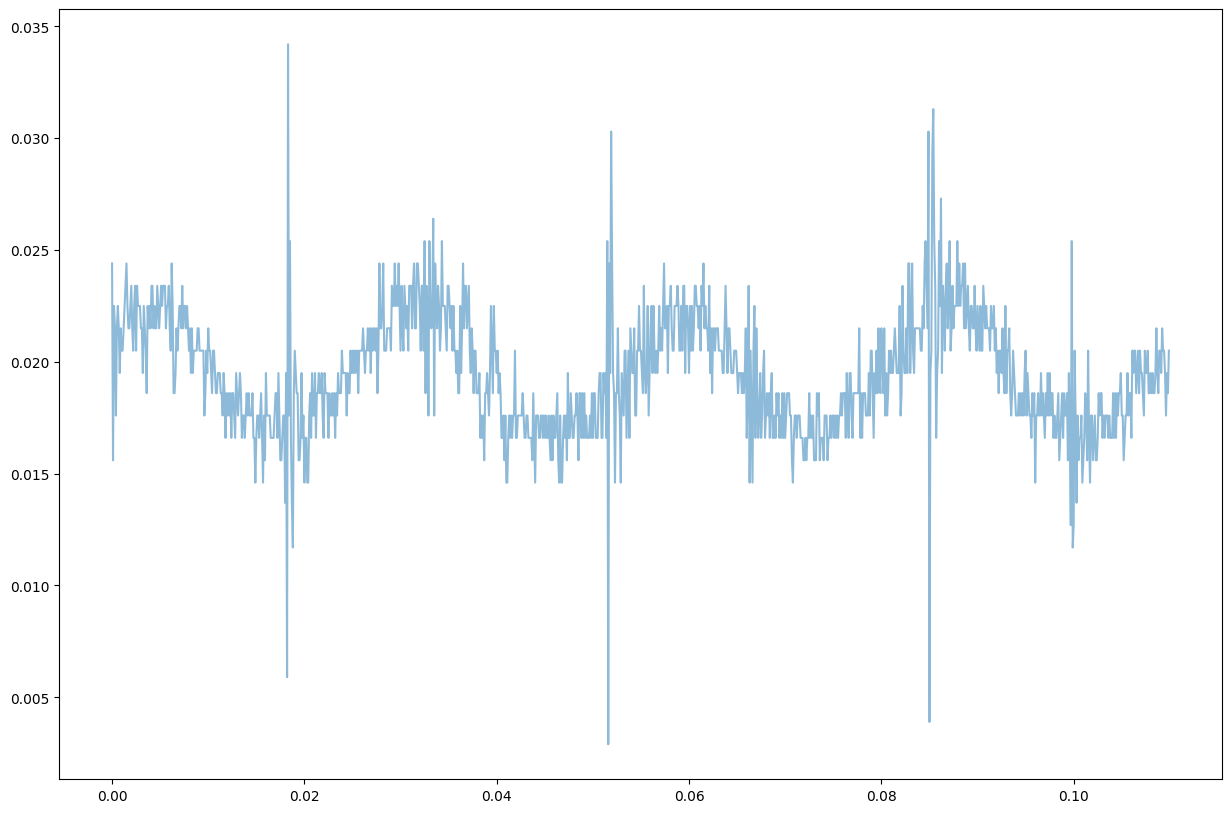

In [2]:
T = 10**(-8)
freq_ADC = 1 / T
col_with_dat_y = 0
lb_sin = 2 * 10**5 #3.34 * 10**5
ub_sin = 5 * 10**5 # 3.98 * 10**5
file_path = 'Характерные файлы/DASdata_7920001_2024-09-28_10-15-04.801_100000000Hz_8192_.csv' #np.loadtxt('Характерные файлы/DASdata_7920001_2024-09-28_10-15-04.801_100000000Hz_8192_.csv')
data = pd.read_csv(file_path, delimiter=';', header=None)

if data[col_with_dat_y].dtype == type(str):
    data[col_with_dat_y] = data[col_with_dat_y].str.replace(',', '.')
    data[col_with_dat_y] = pd.to_numeric(data[col_with_dat_y], errors='coerce')

indexis = list()
y = data[col_with_dat_y].values[1000:2100]
# print(len(y))
# y = y[y > 0.0135]
# print(len(y))
# y = y[y < 0.0274]
# print(len(y))
# y_f = bandstop(data[col_with_dat_y].values , freq_ADC, lb_sin, ub_sin) # Бэндстоп фильтр с настроенными на синусоиду частотами
N = len(y) 
x = np.linspace(0, T * N, num=N, endpoint=False) * 10**4
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# Настройка отображения графиков
plt.rc('font', **{'size': 20})
plt.rc('font', **{'family': "Arial"})
ax.plot(x, y,alpha =0.5)
# ax.plot(x, y_f, alpha =0.5)
fig.show()

(1100,)
(1100,)


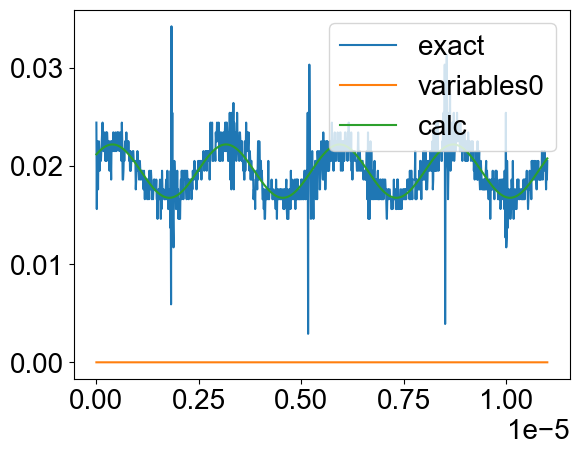

`gtol` termination condition is satisfied.
[1.94616081e-02 2.71631728e-03 7.21958231e+05 6.79669766e-01]


In [27]:
def y(variables, x):
    return (variables[0] + variables[1] * np.sin(variables[2] * np.pi * x + variables[3])) #+ variables[3]

path = r'D:\WhyNotFreeNames\Work\DAS(ПИШ)\Камчатка_обработка_Белоусова\Характерные файлы' + "\\"
ADC_freq = 100 * 10**6
ADC_period = 1 / ADC_freq
os.chdir(path)
files = os.listdir()
data = pd.read_csv(path + files[0], delimiter=';', header=None)
data = np.array(data.values[1000:2100, 0])
print(np.shape(data))
x_scale = np.linspace(0, len(data) * ADC_period, num=len(data))
print(np.shape(x_scale))
K = 1; r = 10; t0 = 50; noise = 0
# ys = y([K, r, t0], x_scale) + noise * np.random.rand(x_scale.shape[0])

def fun(variables):
    return y(variables, x_scale) - data

variables0 = [0.019,0.0027,7.2* 10**5, 0]
res1 = least_squares(fun, variables0, bounds=[(0, 10**(-5), 7*10**5, 0), (1, 0.03, 8*10**5, 3)]) # , ftol=None, xtol=None
plt.plot(x_scale, data, label='exact')
plt.plot(x_scale, y(variables0, x_scale), label='variables0')
plt.plot(x_scale, y(res1.x, x_scale), label='calc')
# plt.plot(x_scale, res1.fun, label='fun')

plt.legend()
plt.show()
print(res1.message)
print(res1.x)

### МНК

In [ ]:
def test_sin(x, shift, ampl, phase, freq):
    return shift + ampl * np.sin(freq * x + phase)

In [ ]:
# x = np.array([0, 0.01, 0.02, 0.03, 0.04])
x = np.linspace(0, T * N, num=N, endpoint=False)
X = np.stack((np.ones(len(x)), x, x**2, x**3)).T
# print(X)
print(len(y))
print(np.shape(X))
k, residuals, rank, sv = lstsq(X, y)#, rcond=10**(-6))
print("Beta:", k)
print("Residuals:", residuals)
print("Rank:", rank)
print("SV:", sv)

In [ ]:
# Вычисление коэфициентов
test_freq = np.sqrt((18 * k[3]**2) / (k[2]**2 - 3 * k[1] * k[3]))
test_phase = (k[2] * test_freq) / (3 * k[3])
test_ampl = (-6 * k[3]) / test_freq**3
test_shift = k[0] - test_phase * test_ampl + (test_ampl * test_phase**3) / 6
print(test_shift, test_ampl, test_phase, test_freq)

In [ ]:
# Построение графика
# plt.plot(x, test_sin(x, test_shift, test_ampl, test_phase, test_freq), label='approx')
plt.plot(x, k[0] + x * k[1] + x**2 * k[2] + x**3 * k[3], label='approx_poly')
plt.plot(x, y, label='acc')
plt.legend(loc='best')
plt.show()

### Метод градиентного спуска

In [ ]:
def F(s, a, nu, phi, x, y):
    return (s + a * np.sin(nu * x + phi) - y)**2
def dF_ds(s, a, nu, phi, x, y):
    return 2 * s + 2 * a * np.sin(nu * x + phi) - 2 * y
def sum_dF_ds(s, a, nu, phi, x_array, y_array):
    return np.sum(np.array([dF_ds(s, a, nu, phi, x, y)**2 for x, y in zip(x_array, y_array)]))
def dF_da(s, a, nu, phi, x, y):
    return 2 * (s + a * np.sin(nu * x + phi) - y) * np.sin(nu * x + phi)
def sum_dF_da(s, a, nu, phi, x_array, y_array):
    return np.sum(np.array([dF_da(s, a, nu, phi, x, y)**2 for x, y in zip(x_array, y_array)]))
def dF_dnu(s, a, nu, phi, x, y):
    return 2 * (s + a * np.sin(nu * x + phi) - y) * a * x * np.cos(nu * x + phi)
def sum_dF_dnu(s, a, nu, phi, x_array, y_array):
    return np.sum(np.array([dF_dnu(s, a, nu, phi, x, y)**2 for x, y in zip(x_array, y_array)]))
def dF_dphi(s, a, nu, phi, x, y):
    return 2 * (s + a * np.sin(nu * x + phi) - y) * a * np.cos(nu * x + phi)
def sum_dF_dphi(s, a, nu, phi, x_array, y_array):
    return np.sum(np.array([dF_dphi(s, a, nu, phi, x, y)**2 for x, y in zip(x_array, y_array)]))
def norm(s, a, nu, phi, x_array, y_array, lmbda):
    return np.sum(np.array([F(s - lmbda * sum_dF_ds(s, a, nu, phi, x_array, y_array), a - lmbda * sum_dF_da(s, a, nu, phi, x_array, y_array), nu - lmbda * sum_dF_dnu(s, a, nu, phi, x_array, y_array), phi - lmbda * sum_dF_dphi(s, a, nu, phi, x_array, y_array), x, y) for x, y in zip(x_array, y_array)]))

In [ ]:
def find_lambda(s, a, nu, phi, x_array, y_array):
    eps_add = 10**(-6)
    LB = -1
    RB = 1
    count = 0
    while (norm(s, a, nu, phi, x_array, y_array, LB) * norm(s, a, nu, phi, x_array, y_array, RB)) > 0:
        print(str(norm(s, a, nu, phi, x_array, y_array, LB)).ljust(10), str(norm(s, a, nu, phi, x_array, y_array, RB)).ljust(10))# , end="\r")
        LB *= 10
        RB *= 10
        # count += 1
        # print(count)
    print(1)
    while RB - LB > eps_add:
        if (norm(s, a, nu, phi, x_array, y_array, LB) * norm(s, a, nu, phi, x_array, y_array, (RB + LB) // 2)) < 0:
            LB = (RB + LB) // 2
        elif (norm(s, a, nu, phi, x_array, y_array, (RB + LB) // 2) * norm(s, a, nu, phi, x_array, y_array, RB)) < 0:
            RB = (RB + LB) // 2
        else:
            raise IndexError("")
    return LB

In [ ]:
file_path = 'Характерные файлы/DASdata_7920001_2024-09-28_10-15-04.801_100000000Hz_8192_.csv' #np.loadtxt('Характерные файлы/DASdata_7920001_2024-09-28_10-15-04.801_100000000Hz_8192_.csv')
data = pd.read_csv(file_path, delimiter=';', header=None)

if data[col_with_dat_y].dtype == type(str):
    data[col_with_dat_y] = data[col_with_dat_y].str.replace(',', '.')
    data[col_with_dat_y] = pd.to_numeric(data[col_with_dat_y], errors='coerce')

y_array = np.array(data[col_with_dat_y].values[1000:1250])
N = len(y_array) 
x_array = np.linspace(0, T * N, num=N, endpoint=False) 

In [ ]:
# s — shift
# a - ampl
# nu - freq
# phi - phase
eps = 10**(-5)
s_0 = 0.2
a_0 = 0.5
nu_0 = 1 
phi_0 = 0
sum_F_0 = np.sum(np.array([F(s_0, a_0, nu_0, phi_0, x, y) for x, y in zip(x_array, y_array)]))
print(sum_F_0)
lmbda = find_lambda(s_0, a_0, nu_0, phi_0, x_array, y_array)
s = s_0 - lmbda * np.sum(np.array([dF_ds(s_0, a_0, nu_0, phi_0, x, y) for x, y in zip(x_array, y_array)]))
a = a_0 - lmbda * np.sum(np.array([dF_ds(s_0, a_0, nu_0, phi_0, x, y) for x, y in zip(x_array, y_array)]))
nu = nu_0 - lmbda * np.sum(np.array([dF_ds(s_0, a_0, nu_0, phi_0, x, y) for x, y in zip(x_array, y_array)]))
phi = phi_0 - lmbda * np.sum(np.array([dF_ds(s_0, a_0, nu_0, phi_0, x, y) for x, y in zip(x_array, y_array)]))
sum_F = np.sum(np.array([F(s, a, nu, phi, x, y) for x, y in zip(x_array, y_array)]))
while np.abs(sum_F - sum_F_0) > eps:
    print(np.abs, end="\r")
    s_0 = s
    a_0 = a
    nu_0 = nu
    phi_0 = phi
    sum_F_0 = sum_F
    lmbda = find_lambda(s_0, a_0, nu_0, phi_0, x_array, y_array)
    s = s_0 - lmbda * np.sum(np.array([dF_ds(s_0, a_0, nu_0, phi_0, x, y) for x, y in zip(x_array, y_array)]))
    a = a_0 - lmbda * np.sum(np.array([dF_ds(s_0, a_0, nu_0, phi_0, x, y) for x, y in zip(x_array, y_array)]))
    nu = nu_0 - lmbda * np.sum(np.array([dF_ds(s_0, a_0, nu_0, phi_0, x, y) for x, y in zip(x_array, y_array)]))
    phi = phi_0 - lmbda * np.sum(np.array([dF_ds(s_0, a_0, nu_0, phi_0, x, y) for x, y in zip(x_array, y_array)]))
    sum_F = np.sum(np.array([F(s, a, nu, phi, x, y) for x, y in zip(x_array, y_array)]))
    # print("F() =", sum_F)
    # print("Shift =", s)
    # print("Amplitude =", a)
    # print("Freq =", nu)
    # print("Phase =", phi)
print("F() =", sum_F)
print("Shift =", s)
print("Amplitude =", a)
print("Freq =", nu)
print("Phase =", phi)

In [ ]:
# x = np.linspace(-10,40,num=4000, endpoint=True)
# y = np.sin(2*x + 0.5 * np.pi) #+ np.sin(5 * x)
# plt.plot(x, y)
# plt.show()

In [ ]:
# freqs, spectrum = signal.periodogram(y, fs=freq_ADC)
# spec_amps = np.abs(spectrum)
# fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# # Настройка отображения графиков
# plt.rc('font', **{'size': 20})
# plt.rc('font', **{'family': "Arial"})
# ax.plot(freqs, spectrum)
# fig.show()

In [ ]:
# fft_data = np.fft.rfft(y)
# fft_freqs = np.fft.rfftfreq(len(y), d=T)
# fft_amps = np.abs(fft_data) # амплитуды, увеличенные в 2000 раз
# fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# # Настройка отображения графиков
# plt.rc('font', **{'size': 20})
# plt.rc('font', **{'family': "Arial"})
# ax.plot(fft_freqs, fft_amps)
# fig.show()

In [ ]:
# freqs_max = 0
# freqs_inds_fft = 0
# for i in range(len(fft_freqs)):
#     # print(freqs_max <= fft_amps[i])
#     if lb_sin <= fft_freqs[i] <= ub_sin and freqs_max <= fft_amps[i]:
#         freqs_inds_fft = i
#         freqs_max = fft_amps[i]
#         print(1)
# freqs_max = 0
# freqs_inds = 0
# for i in range(len(freqs)):
#     if lb_sin <= freqs[i] <= ub_sin and freqs_max <= spec_amps[i]:
#         freqs_inds = i
#         freqs_max = spec_amps[i]
#         print(2)
# print(freqs_inds_fft, freqs_inds)

In [ ]:
# print("Amplitudes fft:", fft_amps[freqs_inds_fft]*2/len(x))
# print("Frequency fft:", fft_freqs[freqs_inds_fft]*2*np.pi)
# print("Phases fft:", (np.angle(fft_freqs[freqs_inds_fft]) - min(x)*fft_freqs[freqs_inds_fft]*2*np.pi)/np.pi)

In [ ]:
# print("Amplitudes:", spec_amps[freqs_inds]*2/len(x))
# print("Frequency:", freqs[freqs_inds]*2*np.pi)
# print("Phases:", (np.angle(freqs[freqs_inds]) - min(x)*freqs[freqs_inds]*2*np.pi)/np.pi)